# Stock Price Prediction

## Imports

In [3]:
%%bash
pip install ta yfinance tensorflow pandas_datareader numpy matplotlib numpy seaborn scikit-learn scikit-image holidays PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.0/852.0 kB 9.3 MB/s eta 0:00:00


In [44]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import math
import pandas_datareader.data as web
from datetime import datetime, timedelta
import ta
import matplotlib.pyplot as plt
import yfinance as yfin
import seaborn as sns
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from keras.optimizers import Adam
import holidays
from dateutil import parser

In [5]:
yfin.pdr_override()
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

## Data Config

In [6]:
stock_ticker = 'WDAY' # Ticker for Workday is WDAY
start_date = datetime(2013, 11, 19) # 19 Nov 2013
end_date = datetime.today() # Today

## Data Prepare

In [7]:
dataset = web.DataReader(stock_ticker, start_date, end_date)
dataset['MACD'] = ta.trend.MACD(close=dataset['Close']).macd()
dataset['RSI'] = ta.momentum.RSIIndicator(close=dataset['Close']).rsi()
dataset['ATR'] = ta.volatility.AverageTrueRange(high=dataset['High'], low=dataset['Low'], close=dataset['Close']).average_true_range()
dataset = dataset.drop(columns=['High', 'Low', 'Adj Close'])
dataset = ta.utils.dropna(dataset)

[*********************100%%**********************]  1 of 1 completed


## Data Exploration

In [8]:
dataset.head()

,Open,Close,Volume,MACD,RSI,ATR
Date,,,,,,
2013-12-26,81.970001,82.510002,837100,1.513870,65.675175,2.177213
2013-12-27,81.730003,82.059998,866400,1.481334,62.777370,2.103126
2013-12-30,81.779999,82.419998,411700,1.467680,64.140518,2.067903
2013-12-31,82.459999,83.160004,595000,1.499288,66.829593,2.003767
2014-01-02,82.279999,81.769997,1058900,1.396083,58.027260,2.047069


In [9]:
dataset.tail()

,Open,Close,Volume,MACD,RSI,ATR
Date,,,,,,
2023-11-16,232.000000,231.949997,1259600,3.447808,65.062346,5.736440
2023-11-17,232.880005,231.660004,1013600,3.732562,64.528222,5.487409
2023-11-20,233.759995,237.020004,1236000,4.340701,69.510468,5.528308
2023-11-21,236.520004,236.679993,955000,4.740574,68.849837,5.364857
2023-11-22,238.009995,234.259995,1313700,4.806792,64.174861,5.345225


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2013-12-26 to 2023-11-22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2495 non-null   float64
 1   Close   2495 non-null   float64
 2   Volume  2495 non-null   int64  
 3   MACD    2495 non-null   float64
 4   RSI     2495 non-null   float64
 5   ATR     2495 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 136.4 KB


In [11]:
dataset.describe()

,Open,Close,Volume,MACD,RSI,ATR
count,2495.000000,2495.000000,2.495000e+03,2495.000000,2495.000000,2495.000000
mean,148.397314,148.451138,1.915045e+06,0.401502,51.986105,4.879120
std,62.617331,62.589546,1.284561e+06,3.804329,11.514926,2.391920
min,48.360001,48.900002,2.827000e+05,-16.135153,20.944820,1.526451
25%,86.320000,86.285000,1.172350e+06,-1.265433,44.113036,2.601518
50%,142.000000,141.839996,1.611800e+06,0.725390,52.584751,4.754054
75%,198.465004,197.899994,2.221950e+06,2.422463,60.418402,6.456760
max,304.519989,300.899994,2.315390e+07,13.703644,84.568323,11.591592


### Original vs Moving Average

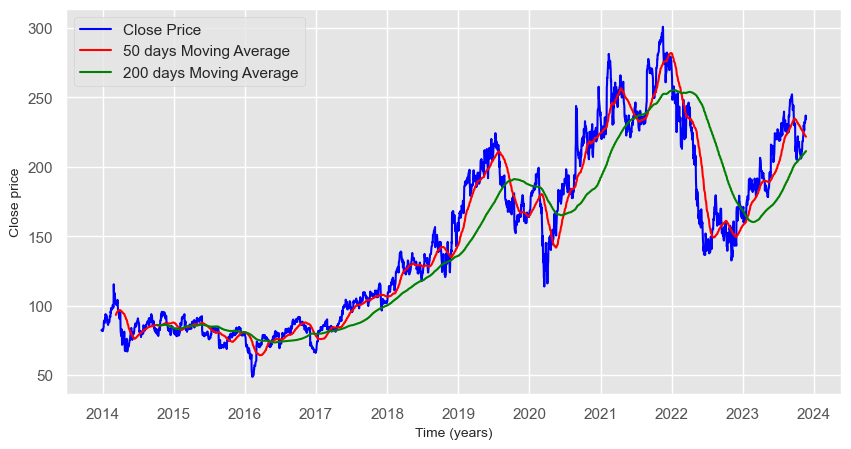

In [12]:
fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(dataset['Close'], 'blue')
plt.plot(dataset['Close'].rolling(50).mean(),'red')
plt.plot(dataset['Close'].rolling(200).mean(),'green')
plt.legend(['Close Price', '50 days Moving Average', '200 days Moving Average'], loc='upper left')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
plt.show()

###  Correlation heatmap

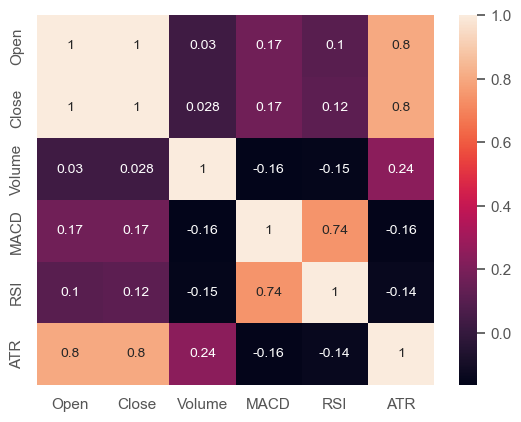

In [13]:
sns.heatmap(dataset.corr(), annot=True)
plt.show()

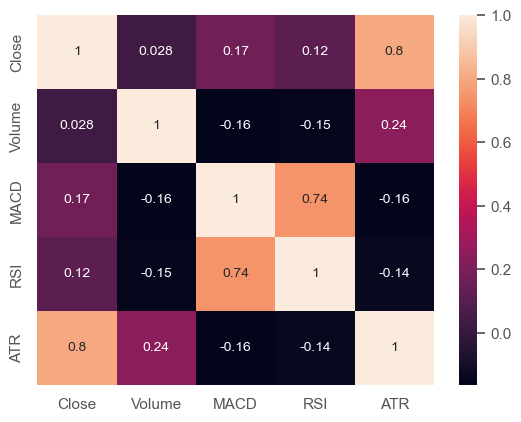

In [14]:
dataset = dataset.iloc[:, 1:]
sns.heatmap(dataset.corr(), annot=True)
plt.show()

### Timeseries Graph

<Figure size 2000x1500 with 0 Axes>

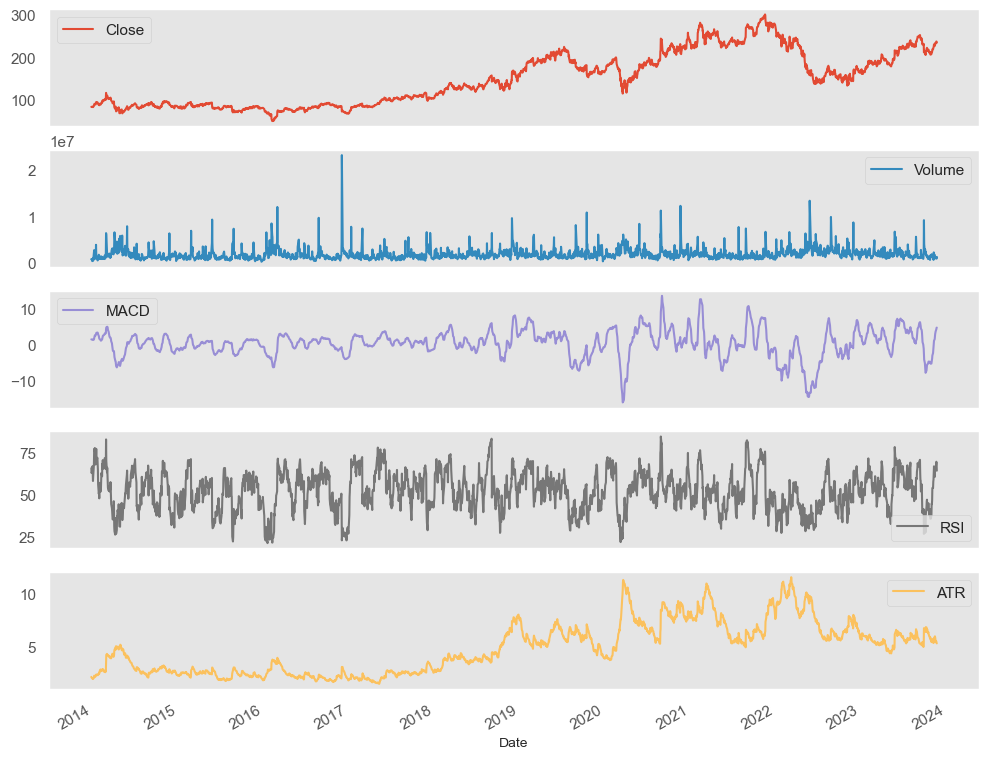

In [15]:
fig = plt.figure(figsize = (20, 15))
dataset.plot(subplots = True, figsize = (12,10), grid=False)
sns.set_style("whitegrid")
plt.show()

## Dataset Denoising and Normalization

### Denoise Dataset

In [16]:
close_denoised = denoise_wavelet(dataset['Close'], wavelet='haar', method='VisuShrink', mode='soft', rescale_sigma = True)

### Scale dataset

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_normalized = scaler.fit_transform(np.array(close_denoised).reshape(-1, 1))

## Prepare test and train data

### Create sequences of data for training

In [18]:
X = []
y = []
time_step = 100
for i in range(len(close_normalized) - time_step):
  X.append(close_normalized[i : i + time_step])
  y.append(close_normalized[i + time_step])

X = np.array(X)
y = np.array(y)

### Splitting training, validation and test data

In [19]:
test_size = 0.2 # Test Data Size = 20%
valid_size = 0.2 # Validation Data Size = 20%

train_pivot = int(len(X) * (1 - (valid_size + test_size)))
valid_pivot = train_pivot + int(len(X) * (valid_size))
X_train, X_valid, X_test = X[:train_pivot], X[train_pivot:valid_pivot], X[valid_pivot:]
y_train, y_valid, y_test = y[:train_pivot], y[train_pivot:valid_pivot], y[valid_pivot:]

## Helper Functions

### Calculate Training, Validation and Test Loss

In [20]:
def calculate_loss(model):
  train_loss = model.evaluate(X_train, y_train, verbose=1)
  valid_loss = model.evaluate(X_valid, y_valid, verbose=1)
  test_loss = model.evaluate(X_test, y_test, verbose=1)
  return train_loss, valid_loss, test_loss

### Predict Training, Validation and Test Data

In [21]:
def predict(model):
  train_predictions = model.predict(X_train)
  valid_predictions = model.predict(X_valid)
  test_predictions = model.predict(X_test)
  return train_predictions, valid_predictions, test_predictions

### Inverse to Original Scale

In [22]:
def inverse(data):
  return scaler.inverse_transform(data)

### Plot actual and predicted data

In [23]:
def plot_actual_predict_data(train_prediction, valid_prediction, test_prediction, title):
  plt.figure(figsize=(12, 6))
  plt.plot(dataset.index, dataset['Close'], label='Actual Prices', color='blue')
  plt.plot(dataset.index[time_step:len(train_prediction) + time_step], train_prediction, label='Predicted Training Prices', color='orange')
  plt.plot(dataset.index[len(train_prediction) + time_step:-len(test_prediction)], valid_prediction, label="Predicted Validation Prices", color="green")
  plt.plot(dataset.index[-len(test_prediction):], test_prediction, label='Predicted Test Prices', color='red')
  plt.title(title)
  plt.xlabel('Date (Years)')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

### Calculate Root Mean Square Error

In [24]:
def rmse(y, y_pred):
  return math.sqrt(mean_squared_error(y, y_pred))

### Mean Absolute Percentage Error

In [25]:
def mape(y, y_pred):
  return mean_absolute_percentage_error(y, y_pred)

### Model Performance Metrices

#### Root Mean Squared Error

In [62]:
train_rmse = rmse(y_train_actual, train_prediction)
valid_rmse = rmse(y_valid_actual, valid_prediction)
test_rmse = rmse(y_test_actual, test_prediction)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 2.6572950200461016
Validation Root Mean Squared Error: 4.303259382515573
Testing Root Mean Squared Error: 4.10220354963665


#### Mean Absolute Percentage Error

In [63]:
train_mape = mape(y_train_actual, train_prediction)
valid_mape = mape(y_valid_actual, valid_prediction)
test_mape = mape(y_test_actual, test_prediction)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.021279261776004296
Validation Mean Absolute Percentage Error: 0.01448422358796772
Testing Mean Absolute Percentage Error: 0.0158673027054879


## Predict Future Price

### Data Config

In [64]:
prediction_days = 100
dates = dataset.index.values
one_day = timedelta(days=1)
holidays_us = holidays.US()


### Calculate next business day

In [65]:
def next_business_day(today):
  next_day = today + one_day
  while next_day.weekday() in holidays.WEEKEND or next_day in holidays_us:
        next_day += one_day
  return next_day

### Create dates dataset

In [66]:
for _ in range(prediction_days):
  last_day = parser.parse(dates[-1].astype(str))
  next_day = np.datetime64(next_business_day(last_day))
  dates = np.append(dates, next_day)

### Helper function for predicting data

In [67]:
def predict_for_days(model, prediction_days, close_price):
  close_price = close_price[-1].reshape(1, time_step, 1)
  predicted_prices = []
  for _ in range(prediction_days):
    prediction = model.predict(close_price, verbose=0)
    predicted_prices.append(prediction[0][0])
    close_price = np.concatenate((close_price[0][1: ], prediction)).reshape(1, time_step, 1)
  predicted_prices = np.array(predicted_prices).reshape(-1, 1)
  return inverse(predicted_prices)

### Compare predictions by plotting predictions using all models

NameError: name 'vanilla_predicted_prices' is not defined

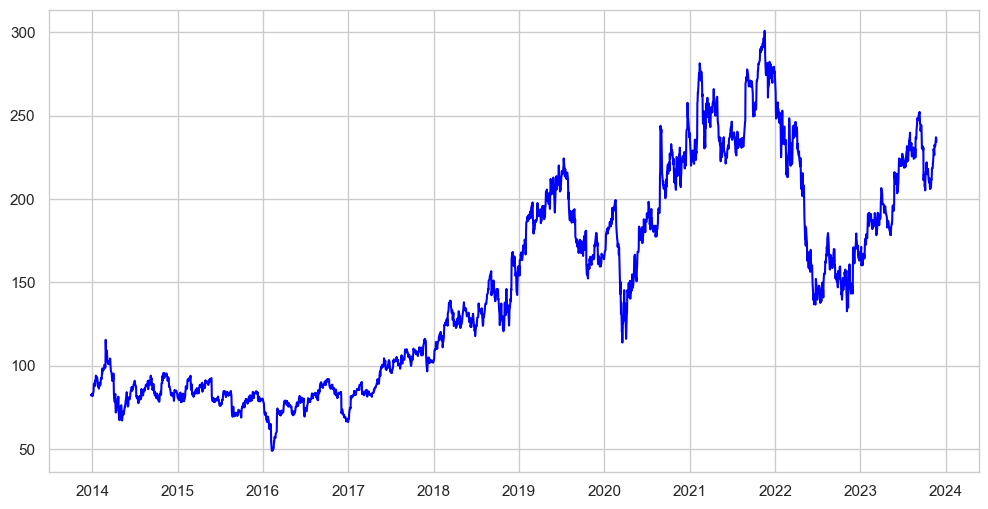

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(dataset['Close'])], dataset['Close'], label='Actual Prices', color='blue')
plt.plot(dates[-1 * len(vanilla_predicted_prices): ], vanilla_predicted_prices, label='Vanilla RNN Predicted Prices', color='red')
plt.plot(dates[-1 * len(gru_predicted_prices): ], gru_predicted_prices, label='GRU RNN Predicted Prices', color='orange')
plt.plot(dates[-1 * len(lstm_predicted_prices): ], lstm_predicted_prices, label='LSTM RNN Predicted Prices', color='green')
plt.title("Predicted Data")
plt.xlabel('Date (Years)')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import AdamW, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True,
                   input_shape=(100, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adamW', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adamW':
        optimizer = AdamW(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=8,
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning1')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history=best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)

Trial 8 Complete [00h 01m 29s]
val_loss: 0.004186897538602352

Best val_loss So Far: 0.002369583584368229
Total elapsed time: 00h 24m 35s
Best Hyperparameters:
Units: 128
Optimizer: adamW
Learning Rate: 0.0002795460351385751
Batch Size: 64


Epoch 1/100
23/23 [==============================] - 7s 253ms/step - loss: 0.0186 - val_loss: 0.0377
Epoch 2/100
23/23 [==============================] - 5s 238ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 3/100
23/23 [==============================] - 5s 240ms/step - loss: 6.0916e-04 - val_loss: 0.0031
Epoch 4/100
23/23 [==============================] - 6s 244ms/step - loss: 5.4693e-04 - val_loss: 0.0029
Epoch 5/100
23/23 [==============================] - 6s 249ms/step - loss: 5.2396e-04 - val_loss: 0.0028
Epoch 6/100
23/23 [==============================] - 6s 249ms/step - loss: 5.2454e-04 - val_loss: 0.0035
Epoch 7/100
23/23 [==============================] - 6s 245ms/step - loss: 4.9610e-04 - val_loss: 0.0029
Epoch 8/100
23/23 [==============================] - 5s 238ms/step - loss: 4.8059e-04 - val_loss: 0.0027
Epoch 9/100
23/23 [==============================] - 5s 237ms/step - loss: 4.7771e-04 - val_loss: 0.0035
Epoch 10/100
23/23 [==============================] - 5s 230ms/

In [69]:
train_loss, valid_loss, test_loss = calculate_loss(best_model)
print(f'Training Loss: {train_loss},\nValidation Loss: {valid_loss}\nTesting Loss: {test_loss}')

15/15 [==============================] - 1s 52ms/step - loss: 4.9636e-04
Training Loss: 0.00012449600035324693,
Validation Loss: 0.001031561871059239
Testing Loss: 0.0004963585524819791


In [70]:
train_prediction, valid_prediction, test_prediction = predict(best_model)

15/15 [==============================] - 1s 53ms/step


In [71]:
train_prediction, valid_prediction, test_prediction = inverse(train_prediction), inverse(valid_prediction), inverse(test_prediction)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [72]:
train_rmse = rmse(y_train_actual, train_prediction)
valid_rmse = rmse(y_valid_actual, valid_prediction)
test_rmse = rmse(y_test_actual, test_prediction)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 2.684082277946986
Validation Root Mean Squared Error: 7.726198555024951
Testing Root Mean Squared Error: 5.3593971105495335


In [73]:
train_mape = mape(y_train_actual, train_prediction)
valid_mape = mape(y_valid_actual, valid_prediction)
test_mape = mape(y_test_actual, test_prediction)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.014202346582763868
Validation Mean Absolute Percentage Error: 0.026926514444303353
Testing Mean Absolute Percentage Error: 0.019924227290308107


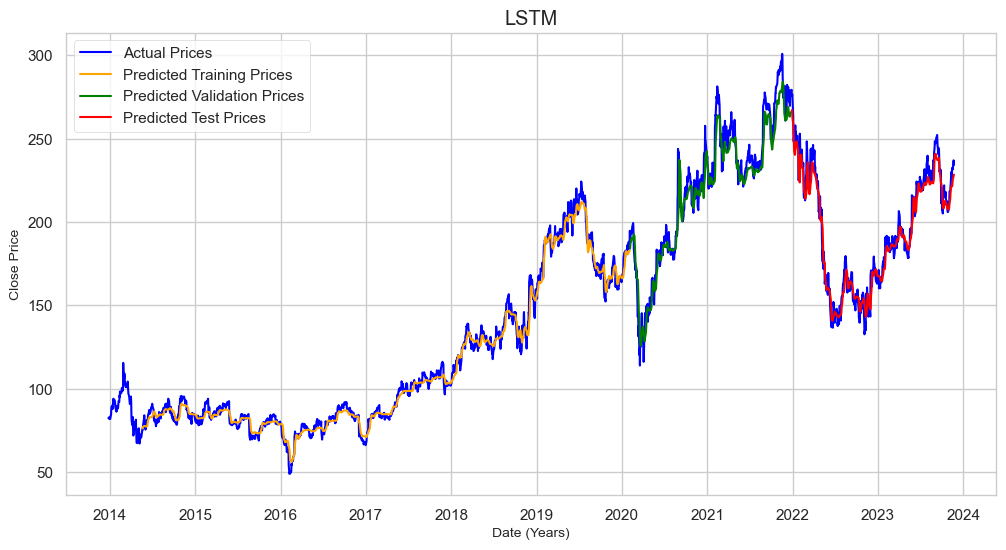

In [74]:
plot_actual_predict_data(train_prediction, valid_prediction, test_prediction, "LSTM")

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model1(hp):
    model1 = Sequential()
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        return_sequences=True,
                        input_shape=(100, 1)))
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        return_sequences=True))
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model1.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adamW', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adamW':
        optimizer = AdamW(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model1.compile(loss='mean_squared_error', optimizer=optimizer)
    return model1

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model1,
    objective='val_loss',
    max_trials=8,
    directory='my_dir',
    project_name='rnn_hyperparameter_tuning1')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15)

# Get the best hyperparameters
best_hps1 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps1.get('units')}")
print(f"Optimizer: {best_hps1.get('optimizer')}")
print(f"Learning Rate: {best_hps1.get('learning_rate')}")
print(f"Batch Size: {best_hps1.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model1 = tuner.hypermodel.build(best_hps1)
history1 = best_model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)


Trial 8 Complete [00h 00m 25s]
val_loss: 0.008316243067383766

Best val_loss So Far: 0.001824090490117669
Total elapsed time: 00h 02m 36s
Best Hyperparameters:
Units: 64
Optimizer: adamW
Learning Rate: 0.00575233871701001
Batch Size: 64
Epoch 1/100
23/23 [==============================] - 1s 35ms/step - loss: 0.2488 - val_loss: 0.1694
Epoch 2/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0256 - val_loss: 0.1727
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 4/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 5/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/100
23/23 [==============================] - 1s 32ms/step - loss: 2.2413e-04 - val_loss: 0.0021
Epoch 7/100
23/23 [==============================] - 1s 32ms/step - loss: 1.4294e-04 - val_loss: 0.0023
Epoch 8/100
23/23 [==============================] - 1s

In [76]:
train_loss1, valid_loss1, test_loss1 = calculate_loss(best_model1)
print(f'Training Loss: {train_loss1},\nValidation Loss: {valid_loss1}\nTesting Loss: {test_loss1}')

15/15 [==============================] - 0s 4ms/step - loss: 3.5716e-04
Training Loss: 9.165955998469144e-05,
Validation Loss: 0.0014165042666718364
Testing Loss: 0.0003571590350475162


In [77]:
train_prediction1, valid_prediction1, test_prediction1 = predict(best_model1)

15/15 [==============================] - 0s 4ms/step


In [78]:
train_prediction1, valid_prediction1, test_prediction1 = inverse(train_prediction1), inverse(valid_prediction1), inverse(test_prediction1)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [79]:
train_rmse = rmse(y_train_actual, train_prediction1)
valid_rmse = rmse(y_valid_actual, valid_prediction1)
test_rmse = rmse(y_test_actual, test_prediction1)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 2.303069426619567
Validation Root Mean Squared Error: 9.053722689972007
Testing Root Mean Squared Error: 4.546203319144549


In [95]:
train_mape = mape(y_train_actual, train_prediction1)
valid_mape = mape(y_valid_actual, valid_prediction1)
test_mape = mape(y_test_actual, test_prediction1)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.01709808032430168
Validation Mean Absolute Percentage Error: 0.028468471526410046
Testing Mean Absolute Percentage Error: 0.01672182461691513


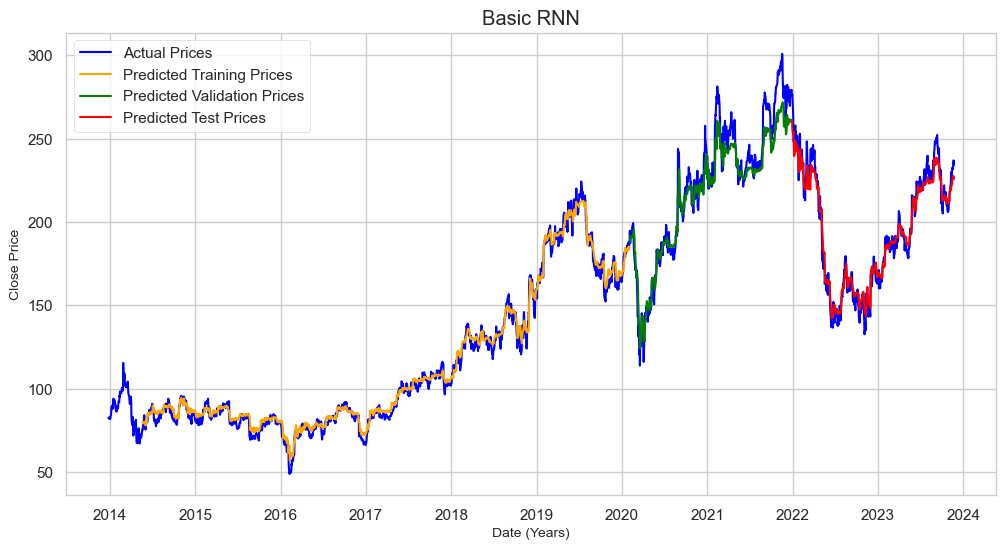

In [96]:
plot_actual_predict_data(train_prediction1, valid_prediction1, test_prediction1, "Basic RNN")

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model2(hp):
    model2 = Sequential()
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True,
                   input_shape=(100, 1)))
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True))
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model2.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adamW', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adamW':
        optimizer = AdamW(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model2.compile(loss='mean_squared_error', optimizer=optimizer)
    return model2

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model2,
    objective='val_loss',
    max_trials=8,
    directory='my_dir',
    project_name='gru_hyperparameter_tuning1')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15)

# Get the best hyperparameters
best_hps2 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps2.get('units')}")
print(f"Optimizer: {best_hps2.get('optimizer')}")
print(f"Learning Rate: {best_hps2.get('learning_rate')}")
print(f"Batch Size: {best_hps2.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model2 = tuner.hypermodel.build(best_hps2)
history2 = best_model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)


Reloading Tuner from my_dir/gru_hyperparameter_tuning1/tuner0.json
Best Hyperparameters:
Units: 96
Optimizer: adamW
Learning Rate: 0.0015662035879940982
Batch Size: 96


Epoch 1/100
23/23 [==============================] - 5s 167ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 2/100
23/23 [==============================] - 4s 159ms/step - loss: 5.1313e-04 - val_loss: 0.0015
Epoch 3/100
23/23 [==============================] - 4s 160ms/step - loss: 1.6933e-04 - val_loss: 9.9733e-04
Epoch 4/100
23/23 [==============================] - 4s 164ms/step - loss: 1.3504e-04 - val_loss: 7.9462e-04
Epoch 5/100
23/23 [==============================] - 4s 166ms/step - loss: 1.2820e-04 - val_loss: 6.9514e-04
Epoch 6/100
23/23 [==============================] - 304s 14s/step - loss: 1.2172e-04 - val_loss: 6.4049e-04
Epoch 7/100
23/23 [==============================] - 4s 160ms/step - loss: 1.1955e-04 - val_loss: 7.0523e-04
Epoch 8/100
23/23 [==============================] - 4s 154ms/step - loss: 1.0895e-04 - val_loss: 6.1583e-04
Epoch 9/100
23/23 [==============================] - 4s 173ms/step - loss: 1.0996e-04 - val_loss: 5.5790e-04
Epoch 10/100
23/23 [===========

In [85]:
train_loss2, valid_loss2, test_loss2 = calculate_loss(best_model2)
print(f'Training Loss: {train_loss2},\nValidation Loss: {valid_loss2}\nTesting Loss: {test_loss2}')

15/15 [==============================] - 1s 50ms/step - loss: 3.6512e-04
Training Loss: 7.339003059314564e-05,
Validation Loss: 0.0007206548471003771
Testing Loss: 0.00036512044607661664


In [86]:
train_prediction2, valid_prediction2, test_prediction2 = predict(best_model2)

15/15 [==============================] - 1s 48ms/step


In [87]:
train_prediction2, valid_prediction2, test_prediction2 = inverse(train_prediction2), inverse(valid_prediction2), inverse(test_prediction2)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [88]:
train_rmse = rmse(y_train_actual, train_prediction2)
valid_rmse = rmse(y_valid_actual, valid_prediction2)
test_rmse = rmse(y_test_actual, test_prediction2)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 2.0608036588440424
Validation Root Mean Squared Error: 6.457761777047523
Testing Root Mean Squared Error: 4.5965929222349775


In [89]:
train_mape = mape(y_train_actual, train_prediction2)
valid_mape = mape(y_valid_actual, valid_prediction2)
test_mape = mape(y_test_actual, test_prediction2)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.01015806695741582
Validation Mean Absolute Percentage Error: 0.02369698974935955
Testing Mean Absolute Percentage Error: 0.018334154643945732


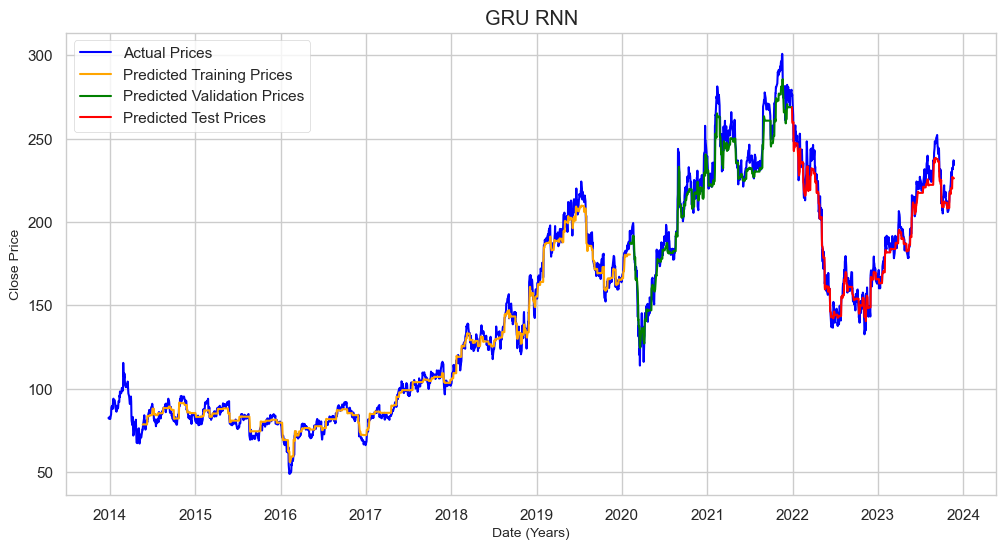

In [90]:
plot_actual_predict_data(train_prediction2, valid_prediction2, test_prediction2, "GRU RNN")